# Machine-Guided Discovery of a Real-World Rogue Wave Model

Generate plots for the paper.

In [1]:
import os
from typing import Tuple
import glob
from functools import partial
import math

from tqdm.notebook import tqdm
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import aquarel
theme = (
    aquarel.load_theme("arctic_light")
    .set_grid(draw=True, width=0.5)
    .set_font(family="sans-serif", sans_serif=["Source Sans Pro"])
    .set_color(grid_color="white", text_color="black", plot_background_color="0.95")
)
theme.apply()
cmap = plt.get_cmap("Blues_r")

from PyALE import ale

from sklearn.preprocessing import RobustScaler

import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax


In [2]:
%load_ext watermark
%watermark
%watermark -iv

Last updated: 2023-08-14T14:00:03.393888+02:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.8.0

Compiler    : Clang 14.0.3 (clang-1403.0.22.14.1)
OS          : Darwin
Release     : 22.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

optax     : 0.1.5
pandas    : 1.5.3
scipy     : 1.10.1
aquarel   : 0.0.5
flax      : 0.6.11
matplotlib: 3.7.1
jax       : 0.4.13
numpy     : 1.24.3



In [3]:
DATA_PATH = None

In [4]:
VALIDATION_STATIONS = [
    'fowd_cdip_163p1',
    'fowd_cdip_168p1',
    'fowd_cdip_181p1',
    'fowd_cdip_185p1',
    'fowd_cdip_187p1',
    'fowd_cdip_188p1',
    'fowd_cdip_189p1',
    'fowd_cdip_194p1',
    'fowd_cdip_196p1',
    'fowd_cdip_197p1',
    'fowd_cdip_198p1',
    'fowd_cdip_200p1',
    'fowd_cdip_201p1',
    'fowd_cdip_203p1',
    'fowd_cdip_204p1',
    'fowd_cdip_209p1',
    'fowd_cdip_213p1',
    'fowd_cdip_214p1',
    'fowd_cdip_215p1',
    'fowd_cdip_217p1',
    'fowd_cdip_220p1',
    'fowd_cdip_222p1',
    'fowd_cdip_225p1',
    'fowd_cdip_226p1',
    'fowd_cdip_233p1',
    'fowd_cdip_433p1',
]

infiles = []
validation_infiles = []

for f in sorted(glob.glob(DATA_PATH + "/*-agg.parquet")):
    if any(os.path.basename(f).startswith(s) for s in VALIDATION_STATIONS):
        validation_infiles.append(f)
    else:
        infiles.append(f)
        
len(infiles), len(validation_infiles)

(131, 26)

## Hyperparameters

In [ ]:
MODEL_FEATURE_GROUPS = [
    ["sea_state_dynamic_crest_trough_correlation"],
    [
        "sea_state_dynamic_steepness",
        "sea_state_dynamic_peak_relative_depth_log10",
        "sea_state_dynamic_bandwidth_peakedness",
        "direction_dominant_spread",
    ],
]

In [5]:
# drop all data that falls outside these ranges
BASE_CONSTRAINTS = (
    # excessive skewness
    ('sea_state_dynamic_skewness', -0.5, 0.5),

    # excessive low-frequency drift
    ('sea_state_dynamic_rel_energy_in_frequency_interval_1', 0, 0.1),

    # just no
    ('sea_state_dynamic_kurtosis', -1, 1),
    ('sea_state_dynamic_valid_data_ratio', 0.95, 1.0),
)

LABEL_FEATURE = 'aggregate_100_max_rel_wave_height'
ROGUE_WAVE_THRESHOLD = 2.0

# set random state to ensure reproducibility
RANDOM_SEED = 17

L1_REG = 0
L2_REG = 1e-5
IRM_WEIGHT = 0

LEARNING_RATE = 1e-4
MLP_LAYERS = (32, 16, 8)

TRAIN_SIZE = 0.6

EPOCHS = 50
SWAG_EPOCHS = 50

In [7]:
MODEL_FEATURES = set()
for grp in MODEL_FEATURE_GROUPS:
    MODEL_FEATURES |= set(grp)
MODEL_FEATURES = list(MODEL_FEATURES)

FEATURE_NAMES = {
    "sea_state_dynamic_significant_wave_height_spectral": "Significant wave height",
    "sea_state_dynamic_mean_period_spectral": "Mean period",
    "sea_state_dynamic_peak_relative_depth_log10": "Relative depth (log$_{10}$)",
    "sea_state_dynamic_peak_relative_depth": "Relative depth",
    "sea_state_dynamic_steepness": "Peak steepness",
    "sea_state_dynamic_steepness_mean": "Mean steepness",
    "sea_state_dynamic_crest_trough_correlation": "Crest-trough correlation",
    "direction_dominant_spread": "Directional spread",
    "sea_state_dynamic_benjamin_feir_index_peakedness": "Benjamin-Feir index",
    "sea_state_dynamic_peak_ursell_number_log10": "Ursell number (log$_{10}$)",
    "sea_state_dynamic_rel_energy_in_frequency_interval_4": "Rel. wind energy",
    "sea_state_dynamic_bandwidth_peakedness": "Spectral peakedness",
    "sea_state_dynamic_bandwidth_narrowness": "Spectral narrowness",
    "sea_state_dynamic_kurtosis": "Kurtosis",
    "sea_state_dynamic_skewness": "Skewness",
    "sea_state_dynamic_peak_wavelength": "Peak wavelenggth",
    "direction_directionality_index": "Directionality index",
    "direction_directionality_index_log10": "Directionality index (log$_{10}$)",
}

FEATURES_TO_READ = [
    'meta_deploy_latitude',
    'meta_deploy_longitude',
    'meta_water_depth',
    'meta_sampling_rate',
    'sea_state_dynamic_window_length',
    'sea_state_dynamic_start_time',
    'sea_state_dynamic_end_time',
    'sea_state_dynamic_significant_wave_height_spectral',
    'sea_state_dynamic_significant_wave_height_direct',
    'sea_state_dynamic_maximum_wave_height',
    'sea_state_dynamic_rel_maximum_wave_height',
    'sea_state_dynamic_mean_period_direct',
    'sea_state_dynamic_mean_period_spectral',
    'sea_state_dynamic_skewness',
    'sea_state_dynamic_kurtosis',
    'sea_state_dynamic_valid_data_ratio',
    'sea_state_dynamic_peak_wave_period',
    'sea_state_dynamic_peak_wavelength',
    'sea_state_dynamic_steepness',
    'sea_state_dynamic_bandwidth_peakedness',
    'sea_state_dynamic_bandwidth_narrowness',
    'sea_state_dynamic_benjamin_feir_index_peakedness',
    'sea_state_dynamic_crest_trough_correlation',
    'direction_peak_wave_direction',
    'direction_directionality_index',
    'sea_state_dynamic_rel_energy_in_frequency_interval_1',
    'sea_state_dynamic_rel_energy_in_frequency_interval_2',
    'sea_state_dynamic_rel_energy_in_frequency_interval_3',
    'sea_state_dynamic_rel_energy_in_frequency_interval_4',
    'sea_state_dynamic_rel_energy_in_frequency_interval_5',
    'direction_dominant_spread_in_frequency_interval_1',
    'direction_dominant_spread_in_frequency_interval_2',
    'direction_dominant_spread_in_frequency_interval_3',
    'direction_dominant_spread_in_frequency_interval_4',
    'direction_dominant_spread_in_frequency_interval_5',
    'direction_dominant_direction_in_frequency_interval_1',
    'direction_dominant_direction_in_frequency_interval_2',
    'direction_dominant_direction_in_frequency_interval_3',
    'direction_dominant_direction_in_frequency_interval_4',
    'direction_dominant_direction_in_frequency_interval_5',
    'sea_state_dynamic_steepness_mean',
    'sea_state_dynamic_peak_relative_depth_log10',
    'sea_state_dynamic_peak_ursell_number_log10',
    'direction_swell_wind_sea_crossing_angle',
    'direction_dominant_direction',
    'direction_dominant_spread',
    'maximum_relative_wave_height_20m',
    'maximum_relative_crest_height_20m',
    'aggregate_100_max_rel_wave_height',
    'aggregate_100_max_rel_crest_height',
    'aggregate_100_start_time',
]

DATA_SUBSETS = {
    'southern-california': dict(
        constraints={
            'meta_deploy_longitude': (-123.5, -117),
            'meta_deploy_latitude': (32, 38)
        }
    ),
    'deep-stations': dict(
        constraints={
            'meta_water_depth': (1000, None),
        }
    ),
    'shallow-stations': dict(
        constraints={
            'meta_water_depth': (None, 100),
        }
    ),
    'summer': dict(
        constraints={
            'day_of_year': (160, 220),
        }
    ),
    'winter': dict(
        constraints={
            'day_of_year': (0, 60),
        }
    ),
    'Hs > 3m': dict(
        constraints={
            'sea_state_dynamic_significant_wave_height_spectral': (3, None),
        },
    ),
    'high-frequency': dict(
        constraints={
            'sea_state_dynamic_rel_energy_in_frequency_interval_2': (None, 0.15),
        }
    ),
    'low-frequency': dict(
        constraints={
            'sea_state_dynamic_rel_energy_in_frequency_interval_2': (0.7, None),
        }
    ),
    'short-period': dict(
        constraints={
            'sea_state_dynamic_mean_period_direct': (None, 6.0),
        }
    ),
    'long-period': dict(
        constraints={
            'sea_state_dynamic_mean_period_direct': (9.0, None),
        }
    ),
    'cnoidal': dict(
        constraints={
            'sea_state_dynamic_peak_ursell_number': (8, None),
        }
    ),
    'weakly-nonlinear': dict(
        constraints={
            'sea_state_dynamic_steepness': (0.04, None),
        }
    ),
    'low-spread': dict(
        constraints={
            'direction_dominant_spread': (None, 20),
        }
    ),
    'high-spread': dict(
        constraints={
            'direction_dominant_spread': (40, None),
        }
    )
}


In [8]:
def read_files(infiles, features=FEATURES_TO_READ):
    """Read all parquet input files into a single pandas DataFrame."""
    if isinstance(infiles, str):
        infiles = [infiles]

    df = []

    for f in tqdm(infiles):
        dfi = pd.read_parquet(f, columns=features)
        df.append(dfi)

    df = pd.concat(df, copy=False)
    df.rename_axis(("aggregate_id_local", "meta_station_name"), inplace=True)
    return df


def drop_invalid(df, target_features):
    mask = np.all(np.isfinite(df[target_features]), axis=1)
    return df[mask]


def convert_log_features(df):
    for feature in df.columns:
        if not feature.endswith("_log10"):
            continue

        feature_stripped = feature[:-len("_log10")]
        df[feature_stripped] = 10 ** df[feature]

    for feature in ("direction_directionality_index",):
        if feature not in df.columns:
            continue
        df[f"{feature}_log10"] = np.log10(df[feature])

    return df


def apply_constraints(df, constraints):
    """Remove all data violating constraints."""
    n_rows = df.shape[0]
    mask = np.ones(n_rows, dtype='bool')

    for feature, lower, upper in constraints:
        if lower is not None:
            mask &= df[feature] >= lower

        if upper is not None:
            mask &= df[feature] <= upper

    return df[mask]


def generate_subsets(df, features=None):
    out = {}

    for name, spec in DATA_SUBSETS.items():
        spec_constraints = [(key, *val) for key, val in spec.get("constraints", {}).items()]
        df_sub = apply_constraints(df, spec_constraints)

        spec_stations = spec.get("stations", [])
        if spec_stations:
            allowed_stations = [f"CDIP_{s}p1" for s in spec_stations]
            station_mask = df.index.isin(allowed_stations, "meta_station_name")
            df_sub = df_sub[station_mask]

        out[name] = get_model_inputs(df_sub, features)

    return out


def train_test_split(df, chunk_length=1000, train_ratio=0.66):
    np.random.seed(RANDOM_SEED)

    overhang = len(df) % chunk_length
    df_idx = np.arange(len(df) - overhang).reshape(-1, chunk_length)
    np.random.shuffle(df_idx)
    df_idx = df_idx.flatten()

    train_cutoff = int(len(df_idx) * train_ratio)
    df_train = df.iloc[df_idx[:train_cutoff]]
    df_val = df.iloc[df_idx[train_cutoff:]]

    return df_train, df_val


def get_model_inputs(df, target_features=None):
    if target_features is not None:
        x = df[target_features]
    else:
        x = df
    y = df[LABEL_FEATURE] > ROGUE_WAVE_THRESHOLD
    return x, y

In [9]:
df_all = read_files(infiles)
df_all = convert_log_features(df_all)
df_all = drop_invalid(df_all, MODEL_FEATURES)
df_all = apply_constraints(df_all, BASE_CONSTRAINTS)

df_all["day_of_year"] = df_all.aggregate_100_start_time.dt.dayofyear

  0%|          | 0/131 [00:00<?, ?it/s]

In [10]:
df_train, df_val = train_test_split(df_all, train_ratio=TRAIN_SIZE)

x_train, y_train = get_model_inputs(df_train, MODEL_FEATURES)
x_val, y_val = get_model_inputs(df_val, MODEL_FEATURES)

preprocess = RobustScaler(quantile_range=(1e-2, 100 - 1e-2))
preprocess.fit(x_train)

x_train = preprocess.transform(x_train)
x_val = preprocess.transform(x_val)

x_train, y_train, x_val, y_val = (
    jnp.array(v, dtype="float32")
    for v in (x_train, y_train, x_val, y_val)
)

In [11]:
print("\n".join([
    f"train samples: {len(y_train)}",
    f"train base rate: {np.count_nonzero(y_train) / len(y_train)}",
    f"val samples: {len(y_val)}",
    f"val base rate: {np.count_nonzero(y_val) / len(y_val)}",
]))

train samples: 7083600
train base rate: 0.00776243717883562
val samples: 4722400
val base rate: 0.007823140775876673


In [12]:
sub_df = generate_subsets(df_val)
sub_df["full"] = (df_val, y_val)

sub_xy = {}

for subset, (sub_x, sub_y) in sub_df.items():
    sub_x_pre = preprocess.transform(sub_x[MODEL_FEATURES])
    sub_xy[subset] = (
        jnp.array(sub_x_pre, dtype="float32"),
        jnp.array(sub_y, dtype="float32"),
    )

for subset, (sub_x, sub_y) in sub_xy.items():
    print(f"{subset}: {len(sub_y) / 1e6:.2f}M")

southern-california: 2.65M
deep-stations: 0.28M
shallow-stations: 1.54M
summer: 0.51M
winter: 0.91M
Hs > 3m: 0.58M
high-frequency: 0.43M
low-frequency: 0.46M
short-period: 1.00M
long-period: 0.42M
cnoidal: 0.40M
weakly-nonlinear: 0.84M
low-spread: 0.25M
high-spread: 0.26M
full: 4.72M


## Theory baselines

In [13]:
def tayfun_cdf(h, r, bfi, R):
    return (
        np.sqrt((1 + r) / (2 * r))
        * (1 + (1 - r**2) / (64 * r * h**2))
        * np.exp(-4 / (1 + r) * h**2)
    )

def rayleigh_cdf(h, r, bfi, R):
    return np.exp(-2 * h**2) * np.ones(np.asarray(r).shape)

def janssen_factor(h, bfi, R):
    bfi2d = bfi / np.sqrt(1 + 7.1 * R)
    c4 = np.pi / np.sqrt(3) * bfi2d ** 2
    bh = 2 / 3 * h ** 2 * (h ** 2 - 1)
    return 1 + c4 * bh

def janssen_cdf(h, r, bfi, R):
    return janssen_factor(h, bfi, R) * rayleigh_cdf(h, r, bfi, R)

def hybrid_cdf(h, r, bfi, R):
    return janssen_factor(h, bfi, R) * tayfun_cdf(h, r, bfi, R)

## Final equation

In [14]:
def logit(prob):
    return jax.scipy.special.logit(prob)

def inverse_logit(logit):
    return jax.nn.sigmoid(logit)

def inflate(p, fac=100):
    return 1 - (1 - p)**fac

def symreg_model(x):
    x_orig = preprocess.inverse_transform(x)
    sigma = x_orig[:, MODEL_FEATURES.index("direction_dominant_spread")] * np.pi / 180
    r = x_orig[:, MODEL_FEATURES.index("sea_state_dynamic_crest_trough_correlation")]
    eps = x_orig[:, MODEL_FEATURES.index("sea_state_dynamic_steepness")]
    nu = x_orig[:, MODEL_FEATURES.index("sea_state_dynamic_bandwidth_peakedness")]
    kd = 10 ** x_orig[:, MODEL_FEATURES.index("sea_state_dynamic_peak_relative_depth_log10")]
    p = 1 / np.sqrt(sigma) * np.exp(
        3.8 * r
        - 12.
        + eps * (
            66. * eps
            - np.sqrt(1 / eps)
            - 0.23 / (kd * nu)
        )
    )
    return logit(inflate(p))

## Train neural network

In [15]:
class MultiHeadMLP(nn.Module):
    features: Tuple[int]
    hidden_layers: Tuple[int]
    base_rate: float

    def bias_init(self, *args):
        return jnp.array([logit(self.base_rate)])

    def setup(self):
        self.bias = self.param("bias", self.bias_init, (1,), "float32")

    def __call__(self, x_in):
        components = self.eval_heads(x_in)
        return sum(components) + self.bias

    @nn.compact
    def eval_heads(self, x_in):
        out = []
        for head_feat in self.features:
            x = x_in[:, head_feat]
            for layer in self.hidden_layers:
                x = nn.relu(nn.Dense(layer)(x))

            x = nn.Dense(1, use_bias=False)(x)
            out.append(x)

        return out


@partial(jax.jit, static_argnames=("batch_size", "apply_fn"))
def batched_apply(state, features, batch_size, apply_fn=None):
    """Trade some speed for memory efficiency"""
    num_batches = math.ceil(features.shape[0] / batch_size)

    if apply_fn is None:
        apply_fn = state.apply_fn

    out = jnp.empty((features.shape[0], 1))

    def loop_body(i, arr):
        in_i = jax.lax.dynamic_slice_in_dim(features, i * batch_size, batch_size, axis=0)
        out_i = apply_fn({"params": state.params}, in_i)
        return jax.lax.dynamic_update_slice_in_dim(arr, out_i, i * batch_size, axis=0)

    return jax.lax.fori_loop(0, num_batches, loop_body, out)


def find_params_by_node_name(params, node_name):
    from typing import Mapping

    def _is_leaf_fun(x):
        if isinstance(x, Mapping) and jax.tree_util.all_leaves(x.values()):
            return True
        return False

    def _get_key_finder(key):
        def _finder(x):
            if not isinstance(x, Mapping):
                return None
            value = x.get(key)
            return None if value is None else {key: value}
        return _finder

    filtered_params = jax.tree_map(_get_key_finder(node_name), params, is_leaf=_is_leaf_fun)
    filtered_params = [x for x in jax.tree_leaves(filtered_params) if x is not None]

    return filtered_params


@jax.jit
def cross_entropy_regularized(logits, labels, params, irm_weight=0, l2_reg=0, l1_reg=0):
    def cross_entropy(logits, labels):
        logits = jnp.squeeze(logits)
        loss = labels * jax.nn.log_sigmoid(logits) + (1 - labels) * jax.nn.log_sigmoid(-logits)
        return -jnp.mean(loss)

    def invariance(logits, labels):
        def lossgrad(logits, labels): return jax.grad(
            lambda w: cross_entropy(w * logits, labels))(1.0)
        return lossgrad(logits[::2], labels[::2]) * lossgrad(logits[1::2], labels[1::2])

    classification_loss = cross_entropy(logits, labels)
    invariance_loss = irm_weight * invariance(logits, labels)

    l1_loss = 0.
    l2_loss = 0.

    kernel_params = find_params_by_node_name(params, "kernel")
    for param in kernel_params:
        l1_loss += jnp.sum(jnp.abs(param))
        l2_loss += jnp.sum(param ** 2)

    l1_loss = l1_reg * l1_loss
    l2_loss = l2_reg * jnp.sqrt(l2_loss)

    loss = classification_loss + invariance_loss + l1_loss + l2_loss
    return loss


@partial(jax.jit, static_argnames=("loss_fn",))
def get_model_grad(state, features, labels, loss_fn):
    """Computes gradients, loss and accuracy for a single batch."""
    def loss(params):
        logits = state.apply_fn({"params": params}, features)
        return loss_fn(logits, labels, params)

    grad_fn = jax.value_and_grad(loss)
    loss, grads = grad_fn(state.params)
    return grads, loss


@partial(jax.jit, static_argnames=("loss_fn",))
def train_multi_step(state, x_train, y_train, perms, loss_val, loss_fn):
    def loop_body(i, inputs):
        state, loss_val = inputs
        perm = perms[i]
        batch_data = x_train[perm, ...]
        batch_labels = y_train[perm, ...]
        grads, new_loss = get_model_grad(state, batch_data, batch_labels, loss_fn)
        state = state.apply_gradients(grads=grads)
        loss_val += new_loss
        return (state, loss_val)

    return jax.lax.fori_loop(0, perms.shape[0], loop_body, (state, loss_val))


def train_epoch(state, x_train, y_train, batch_size, loss_fn, quiet=False):
    """Train for a single epoch."""
    train_ds_size = len(x_train)
    steps_per_epoch = train_ds_size // batch_size

    perms = jnp.array(np.random.permutation(len(x_train)))
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    num_multisteps = 100
    num_iterations = math.ceil(steps_per_epoch / num_multisteps)
    loss = jnp.zeros(1)

    progress = tqdm(range(num_iterations), leave=False, disable=quiet)

    for i in progress:
        perm_slice = slice(
            i * num_multisteps,
            min((i + 1) * num_multisteps, steps_per_epoch)
        )
        state, loss = train_multi_step(state, x_train, y_train, perms[perm_slice], loss, loss_fn)

    loss /= steps_per_epoch
    return state, float(loss)

In [16]:
np.random.seed(RANDOM_SEED)


def create_train_state(model, learning_rate, num_features):
    """Creates initial `TrainState`."""
    rng = jax.random.PRNGKey(0)
    params = model.init(rng, jnp.ones([1, num_features]))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=tx
    )


@jax.jit
def score(state, x, y, logits=None):
    base_rate = jnp.sum(y) / len(y)
    if logits is None:
        logits = batched_apply(state, x, 1024)[:, 0]
    ignorance = y * jax.nn.log_sigmoid(logits) + (1 - y) * jax.nn.log_sigmoid(-logits)
    ignorance = jnp.mean(ignorance)
    ignorance_base = base_rate * jnp.log(base_rate) + (1 - base_rate) * jnp.log(1 - base_rate)
    return ignorance - ignorance_base


def train(model, x_train, y_train, loss_fn, x_val=None, y_val=None, batch_size=1024, num_epochs=100, learning_rate=LEARNING_RATE, initial_state=None, quiet=False):
    num_features = x_train.shape[1]

    state = create_train_state(model, learning_rate, num_features)

    if initial_state is not None:
        state = state.replace(params=initial_state.params)

    progress = tqdm(range(1, num_epochs + 1), disable=quiet)

    try:
        for epoch in progress:
            state, train_loss = train_epoch(state, x_train, y_train,
                                            batch_size, loss_fn=loss_fn, quiet=quiet)

            train_score = score(state, x_train, y_train)

            if x_val is not None:
                val_score = score(state, x_val, y_val)
            else:
                val_score = 0

            if not quiet:
                progress.write(
                    f"epoch: {epoch: 3d}/{num_epochs}, train_loss: {train_loss:.5f}, "
                    f"train_score: {train_score:.5f}, val_score: {val_score:.5f}"
                )
    except KeyboardInterrupt:
        pass

    return state


base_rate = float(y_train.sum()) / len(y_train)

feature_group_idx = [
    [MODEL_FEATURES.index(feat) for feat in grp]
    for grp in MODEL_FEATURE_GROUPS
]

model_layers = [math.ceil(l / np.sqrt(len(feature_group_idx))) for l in MLP_LAYERS]

model = MultiHeadMLP(
    features=feature_group_idx,
    hidden_layers=model_layers,
    base_rate=base_rate,
)

reg_loss = partial(cross_entropy_regularized, irm_weight=IRM_WEIGHT, l1_reg=L1_REG, l2_reg=L2_REG)

state = train(model, x_train, y_train, x_val=x_val, y_val=y_val, loss_fn=reg_loss, num_epochs=EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/var/folders/fk/g5ssrkz179z1mjmvqn1j3q1m0000gn/T/ipykernel_8697/2543052522.py:65: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  filtered_params = [x for x in jax.tree_leaves(filtered_params) if x is not None]


epoch:   1/50, train_loss: 0.04502, train_score: 0.00067, val_score: 0.00066


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   2/50, train_loss: 0.04485, train_score: 0.00069, val_score: 0.00068


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   3/50, train_loss: 0.04482, train_score: 0.00072, val_score: 0.00070


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   4/50, train_loss: 0.04481, train_score: 0.00073, val_score: 0.00071


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   5/50, train_loss: 0.04480, train_score: 0.00073, val_score: 0.00071


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   6/50, train_loss: 0.04480, train_score: 0.00074, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   7/50, train_loss: 0.04479, train_score: 0.00073, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   8/50, train_loss: 0.04479, train_score: 0.00074, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   9/50, train_loss: 0.04479, train_score: 0.00074, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  10/50, train_loss: 0.04479, train_score: 0.00074, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  11/50, train_loss: 0.04479, train_score: 0.00074, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  12/50, train_loss: 0.04478, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  13/50, train_loss: 0.04478, train_score: 0.00075, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  14/50, train_loss: 0.04478, train_score: 0.00074, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  15/50, train_loss: 0.04478, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  16/50, train_loss: 0.04478, train_score: 0.00075, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  17/50, train_loss: 0.04478, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  18/50, train_loss: 0.04478, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  19/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  20/50, train_loss: 0.04478, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  21/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  22/50, train_loss: 0.04477, train_score: 0.00074, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  23/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  24/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  25/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  26/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  27/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  28/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  29/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  30/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  31/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  32/50, train_loss: 0.04477, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  33/50, train_loss: 0.04476, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  34/50, train_loss: 0.04476, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  35/50, train_loss: 0.04476, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  36/50, train_loss: 0.04476, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  37/50, train_loss: 0.04476, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  38/50, train_loss: 0.04476, train_score: 0.00076, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  39/50, train_loss: 0.04476, train_score: 0.00076, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  40/50, train_loss: 0.04476, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  41/50, train_loss: 0.04476, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  42/50, train_loss: 0.04476, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  43/50, train_loss: 0.04476, train_score: 0.00075, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  44/50, train_loss: 0.04476, train_score: 0.00076, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  45/50, train_loss: 0.04476, train_score: 0.00075, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  46/50, train_loss: 0.04476, train_score: 0.00076, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  47/50, train_loss: 0.04476, train_score: 0.00074, val_score: 0.00072


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  48/50, train_loss: 0.04476, train_score: 0.00076, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  49/50, train_loss: 0.04476, train_score: 0.00076, val_score: 0.00073


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  50/50, train_loss: 0.04476, train_score: 0.00076, val_score: 0.00073


In [17]:
from jax.tree_util import tree_map, tree_flatten


def train_swag(swag_state, x_train, y_train, loss_fn, num_steps, accumulate_every, max_cols_deviation, batch_size=1024, quiet=False):
    """Running variance, Knuth style.
    
    https://www.johndcook.com/blog/standard_deviation/
    """
    swag_param_mean = swag_param_mean_old = swag_state.params
    swag_param_welford_s = tree_map(jnp.zeros_like, swag_state.params)

    deviation = []

    progress = tqdm(range(1, num_steps + 1), disable=quiet)
    n_models = 1

    for epoch in progress:
        swag_state, train_loss = train_epoch(
            swag_state, x_train, y_train, batch_size, loss_fn=loss_fn, quiet=quiet)
        if not quiet:
            progress.write(f"epoch: {epoch: 3d}/{num_steps}, train_loss: {train_loss:.5f}")

        if epoch % accumulate_every == 0:
            swag_param_mean = tree_map(
                lambda x, mean_old: mean_old + (x - mean_old) / n_models,
                swag_state.params,
                swag_param_mean_old,
            )

            swag_param_welford_s = tree_map(
                lambda x, s, mean_old, mean_new: s + (x - mean_old) * (x - mean_new),
                swag_state.params,
                swag_param_welford_s,
                swag_param_mean_old,
                swag_param_mean,
            )

            swag_param_mean_old = swag_param_mean

            n_models += 1

            deviation.append(tree_map(lambda x, y: x - y, swag_state.params, swag_param_mean))
            if len(deviation) > max_cols_deviation:
                deviation = deviation[1:]

    cov_diag = tree_map(lambda s: jnp.maximum(0, s / (n_models - 1)), swag_param_welford_s)
    deviation = tree_map(lambda *args: jnp.stack(args, axis=-1), *deviation)
    return swag_state, (swag_param_mean, cov_diag, deviation)


state, swag_out = train_swag(state, x_train, y_train, loss_fn=reg_loss,
                             num_steps=SWAG_EPOCHS, accumulate_every=1, max_cols_deviation=30)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   1/50, train_loss: 0.04476


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   2/50, train_loss: 0.04476


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   3/50, train_loss: 0.04476


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   4/50, train_loss: 0.04476


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   5/50, train_loss: 0.04476


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   6/50, train_loss: 0.04476


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   7/50, train_loss: 0.04476


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   8/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   9/50, train_loss: 0.04476


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  10/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  11/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  12/50, train_loss: 0.04476


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  13/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  14/50, train_loss: 0.04476


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  15/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  16/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  17/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  18/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  19/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  20/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  21/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  22/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  23/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  24/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  25/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  26/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  27/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  28/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  29/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  30/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  31/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  32/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  33/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  34/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  35/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  36/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  37/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  38/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  39/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  40/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  41/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  42/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  43/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  44/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  45/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  46/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  47/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  48/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  49/50, train_loss: 0.04475


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:  50/50, train_loss: 0.04475


In [18]:
from jax.tree_util import tree_flatten


def sample_swag(state, x, swag_mean, cov_diag, deviation, num_samples):
    k = tree_flatten(deviation)[0][0].shape[-1]

    out = np.empty((x.shape[0], num_samples))
    for i in range(num_samples):
        z2 = jnp.array(np.random.normal(size=(k,)))

        def sample_leaf(swag_mean, cov_diag, deviation):
            z1 = np.random.normal(size=swag_mean.shape)
            return (
                swag_mean
                + 1 / np.sqrt(2) * jnp.sqrt(cov_diag) * z1
                + 1 / np.sqrt(2 * (k - 1)) * jnp.dot(deviation, z2)
            )

        param_sample = tree_map(sample_leaf, swag_mean, cov_diag, deviation)
        sample_state = state.replace(params=param_sample)
        pred_sample = batched_apply(sample_state, x, 1024)
        out[:, i] = np.array(pred_sample[:, 0])

    return out

swag_samples_train = sample_swag(state, x_train, *swag_out, 100)
swag_samples_val = sample_swag(state, x_val, *swag_out, 100)

In [19]:
pred_val = jnp.mean(swag_samples_val, axis=1)
pred_std = jnp.std(swag_samples_val, axis=1)

In [20]:
train_score = score(state, x_train, y_train, logits=swag_samples_train.mean(axis=1))
val_score = score(state, x_val, y_val, logits=swag_samples_val.mean(axis=1))

print(f"train score: {train_score:.3e}, val score: {val_score:.3e}")

train score: 7.612e-04, val score: 7.362e-04


## Read test data

In [21]:
df_test = read_files(validation_infiles)
df_test = convert_log_features(df_test)
df_test = drop_invalid(df_test, MODEL_FEATURES)
df_test["day_of_year"] = df_test.aggregate_100_start_time.dt.dayofyear

x_test, y_test = get_model_inputs(df_test, MODEL_FEATURES)
y_test = y_test.values

x_test = preprocess.transform(x_test.values)

# also compute a score for subsets
sub_df_test = generate_subsets(df_test)
sub_df_test["full"] = (df_test, y_test)

sub_xy_test = {}

for subset, (sub_x, sub_y) in sub_df_test.items():
    sub_x_pre = preprocess.transform(sub_x[MODEL_FEATURES])
    sub_xy_test[subset] = (
        jnp.array(sub_x_pre, dtype="float32"),
        jnp.array(sub_y, dtype="float32"),
    )

swag_test = sample_swag(state, x_test, *swag_out, 100)
pred_test = jnp.mean(swag_test, axis=1)
pred_test_std = jnp.std(swag_test, axis=1)

  0%|          | 0/26 [00:00<?, ?it/s]

/Users/dion/.virtualenvs/science/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


## Check extreme predictions

In [22]:
def deflate(p):
    return 1 - (1 - p) ** (1/100)

In [23]:
mean_pred = swag_samples_val.mean(axis=1)
max_pred_idx = np.argmax(mean_pred)

max_pred_feat = preprocess.inverse_transform(x_val[max_pred_idx].reshape(1, -1))[0]

print(f"max pred: {deflate(inverse_logit(mean_pred[max_pred_idx])):.2e}")

for feat, val in zip(MODEL_FEATURES, max_pred_feat):
    print(f"{feat}: {val:.3f}")
    
min_pred_idx = np.argmin(mean_pred)

min_pred_feat = preprocess.inverse_transform(x_val[min_pred_idx].reshape(1, -1))[0]

print("")
print(f"min pred: {deflate(inverse_logit(mean_pred[min_pred_idx])):.2e}")

for feat, val in zip(MODEL_FEATURES, min_pred_feat):
    print(f"{feat}: {val:.3f}")

max pred: 3.27e-04
sea_state_dynamic_peak_relative_depth_log10: -0.227
sea_state_dynamic_bandwidth_peakedness: 0.140
sea_state_dynamic_crest_trough_correlation: 0.879
sea_state_dynamic_steepness: 0.008
direction_dominant_spread: 13.800

min pred: 1.32e-05
sea_state_dynamic_peak_relative_depth_log10: -1.193
sea_state_dynamic_bandwidth_peakedness: 0.304
sea_state_dynamic_crest_trough_correlation: 0.050
sea_state_dynamic_steepness: 0.020
direction_dominant_spread: 32.531


## Check calibration

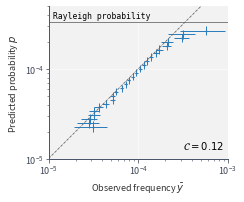

In [24]:
def check_calibration(pred_val, pred_std, y_val, ax=None, line_color="black", rayleigh_text=True):
    bins = np.arange(pred_val.min(), pred_val.max(), 0.1)
    bin_idx = np.digitize(pred_val, bins)

    logit_to_prob = lambda l: deflate(inverse_logit(l))

    calibration_score = 0.
    norm = 0.

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 2.8))

    for i in range(len(bins)):
        bin_mask = bin_idx == i
        bin_means = pred_val[bin_mask]
        bin_stds = pred_std[bin_mask]

        mean_val = bin_means.mean()
        mean_std = bin_stds.mean()

        mean_val_p = logit_to_prob(mean_val)

        true_labels = y_val[bin_mask]
        observed_true = np.count_nonzero(true_labels)
        observed_false = 100 * (len(true_labels) - observed_true)

        if observed_true > 0:
            score_dist = scipy.stats.beta(true_labels.sum(), (1 - true_labels).sum())
            score_mean = score_dist.mean()
            score_ci = score_dist.ppf([0.33, 0.66])
            weight = 1 / (np.log(score_ci[1]) - np.log(score_ci[0]))
            calibration_score += weight * (logit(score_mean) - mean_val) ** 2
            norm += weight

        if observed_true < 10:
            # don't include data points with too few observations
            continue

        observed_dist = scipy.stats.beta(observed_true, observed_false)
        observed_mean = observed_dist.mean()
        observed_ci = observed_dist.ppf([0.025, 0.975])
        
        xerrors = np.abs(np.array(observed_ci) - observed_mean).reshape(2, 1)
        
        yerrors = np.array([
            mean_val_p - logit_to_prob(mean_val - 3 * mean_std), 
            logit_to_prob(mean_val + 3 * mean_std) - mean_val_p
        ]).reshape(2, 1)

        ax.errorbar(observed_mean, mean_val_p, xerr=xerrors, yerr=yerrors, c=line_color, marker="D", markersize=1, elinewidth=1)

    calibration_score = np.sqrt(calibration_score / norm)

    rayleigh_p = rayleigh_cdf(2.0, None, None, None)
    ax.plot([1e-5, 1e-3], [rayleigh_p, rayleigh_p], "-", color="0.4", lw=.8)
    if rayleigh_text:
        ax.annotate("Rayleigh probability", (1e-5, rayleigh_p), (4, 4), textcoords="offset points", font=dict(size=8, family="monospace"))

    ax.plot([1e-5, 1e-3], [1e-5, 1e-3], "--", color="0.4", lw=.8)
    ax.set_xlabel("Observed frequency $\\bar{y}$", color="0.2")
    ax.set_ylabel("Predicted probability $p$", color="0.2")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect("equal")

    ax.set_xlim(1e-5, 1e-3)
    ax.set_ylim(1e-5, 5e-4)

    ax.annotate(f"$\\mathcal{{C}} = {calibration_score:.2f}$", (0.98, 0.05), xycoords="axes fraction", ha="right", va="bottom", fontsize=10)

check_calibration(pred_test, pred_test_std, y_test, line_color=cmap(0.3))
plt.savefig("generated/calibration-nn.pdf", bbox_inches="tight")

/var/folders/fk/g5ssrkz179z1mjmvqn1j3q1m0000gn/T/ipykernel_8697/989991798.py:19: RuntimeWarning: Mean of empty slice.
  mean_std = bin_stds.mean()
/Users/dion/.virtualenvs/science/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


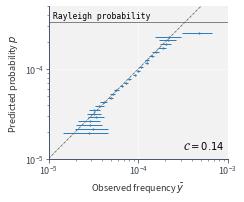

In [25]:
pred_eq_test = symreg_model(x_test)
check_calibration(pred_eq_test, np.zeros_like(pred_eq_test), y_test, line_color=cmap(0.3))
plt.savefig("generated/calibration-symreg.pdf", bbox_inches="tight")

## Visualize prediction surface

In [26]:
def ale_matrix(state, x_orig, out_prefix=None):
    cpu_device = jax.devices("cpu")[0]

    x_orig = jax.device_put(x_orig, cpu_device)
    params_cpu = jax.tree_util.tree_map(lambda x: jax.device_put(x, cpu_device), state.params)
    
    class FakeModel:
        def __init__(self, head_idx):
            self.head_idx = head_idx

        def predict(self, df):
            return state.apply_fn({"params": params_cpu}, df.values, method=model.eval_heads)[self.head_idx][:, 0]

    feature_ranges = np.quantile(preprocess.inverse_transform(x_orig), [1e-4, 1-1e-4], axis=0)
    x_df = pd.DataFrame(np.asarray(x_orig), columns=MODEL_FEATURES)

    def get_name(feat):
        return FEATURE_NAMES.get(feat, feat)
    
    assert len(feature_group_idx) <= 2

    nfeat = max(len(g) for g in feature_group_idx)
    fig, axgrid = plt.subplots(nfeat, nfeat, figsize=(2 * nfeat, 2 * nfeat))
    axgrid = np.atleast_2d(axgrid)
    filled_axes = np.zeros(axgrid.shape, dtype=bool)

    for grp_i, grp in enumerate(feature_group_idx):
        if grp_i == 0:
            axes_j = range(nfeat - 1, -1, -1)
        else:
            axes_j = range(nfeat)

        axes_i = range(nfeat)

        for i, ax_i in enumerate(axes_i):
            for j, ax_j in enumerate(axes_j):
                ax = axgrid[ax_i][ax_j]

                if j > i:
                    continue

                try:
                    feat_i, feat_j = grp[i], grp[j]
                except IndexError:
                    continue

                filled_axes[ax_i][ax_j] = True

                if i == j:
                    feat_name = get_name(MODEL_FEATURES[feat_i])

                    ale_df = ale(
                        X=x_df,
                        model=FakeModel(grp_i),
                        feature=[MODEL_FEATURES[feat_i]],
                        include_CI=False,
                        feature_type="continuous",
                        plot=False,
                        grid_size=20,
                    )

                    fake_grid = np.zeros((len(ale_df.index), len(MODEL_FEATURES)))
                    fake_grid[:, feat_i] = ale_df.index
                    feat_i_inv = preprocess.inverse_transform(fake_grid)[:, feat_i]

                    ax.plot(feat_i_inv, ale_df["eff"].values, color="0.1")
                    ax.set_xlim(*feature_ranges[:, feat_i])
                    ax.set_ylim(-1, 1)
                    ax.set_xlabel(feat_name)
                    ax.set_ylabel("ALE")
                    continue

                feat_name_x = get_name(MODEL_FEATURES[feat_i])
                feat_name_y = get_name(MODEL_FEATURES[feat_j])

                ale_df = ale(
                    X=x_df,
                    model=FakeModel(grp_i),
                    feature=[MODEL_FEATURES[feat_i], MODEL_FEATURES[feat_j]],
                    include_CI=False,
                    feature_type="continuous",
                    plot=False,
                    grid_size=20,
                )

                fake_grid = np.zeros((len(ale_df.index), len(MODEL_FEATURES)))
                fake_grid[:, feat_i] = ale_df.index
                feat_i_inv = preprocess.inverse_transform(fake_grid)[:, feat_i]

                fake_grid = np.zeros((len(ale_df.columns), len(MODEL_FEATURES)))
                fake_grid[:, feat_j] = ale_df.columns
                feat_j_inv = preprocess.inverse_transform(fake_grid)[:, feat_j]

                c = ax.contourf(feat_i_inv, feat_j_inv, ale_df.values.T,
                                levels=np.arange(-1.05, 1.06, 0.1), cmap="RdBu_r")
                cs = ax.contour(feat_i_inv, feat_j_inv, ale_df.values.T,
                                levels=np.arange(-1.05, 1.06, 0.1), colors="black", linewidths=1.0)
                ax.clabel(cs, cs.levels, inline=True, fontsize=7)

                ax.set_xlim(*feature_ranges[:, feat_i])
                ax.set_ylim(*feature_ranges[:, feat_j])
                ax.set_xlabel(feat_name_x)
                ax.set_ylabel(feat_name_y)

    for ax in axgrid[~filled_axes]:
        ax.remove()

    fig.tight_layout(w_pad=1.5, h_pad=1.5)
    plt.subplots_adjust(bottom=0.15)

    axpos = axgrid[0][-1].get_position()
    fig.text(axpos.x0 - 0.08, axpos.y1 + 0.01, "Input head 2", ha="right", va="top", fontsize=12)
    axpos = axgrid[0][0].get_position()
    fig.text(axpos.x1 + 0.05, axpos.y1 + 0.01, "Input head 1", ha="left", va="top", fontsize=12)

    cax = fig.add_axes([0.3, 0.05, 0.4, 0.02], facecolor="white")
    cax.grid(False)

    fig.colorbar(c, cax=cax, orientation="horizontal", label="ALE", ticks=[-1, -0.5, 0, 0.5, 1])

    if out_prefix is not None:
        fig.savefig(f"{out_prefix}.pdf")

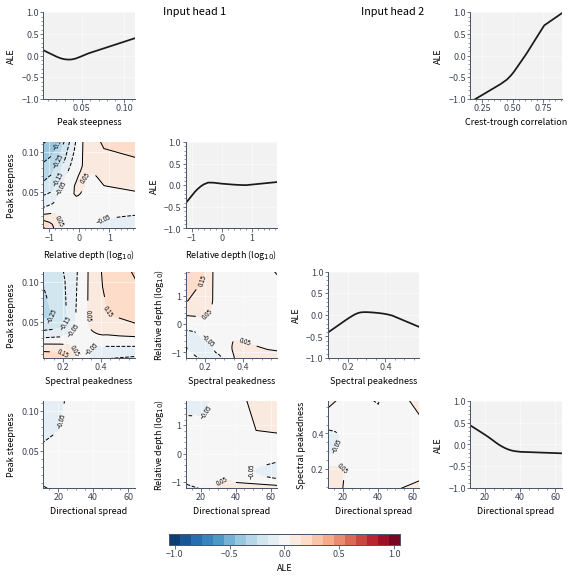

In [27]:
ale_matrix(state, x_train, out_prefix="generated/ale-full")

### Shallow water regime

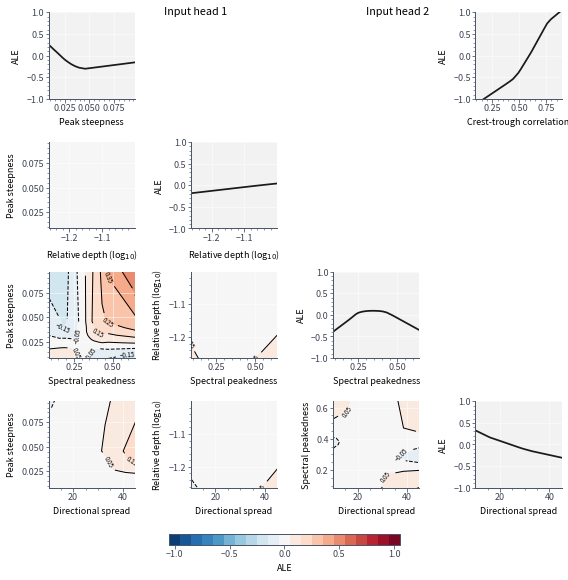

In [28]:
ale_matrix(state, x_train[df_train["sea_state_dynamic_peak_relative_depth_log10"].values < -1], out_prefix="generated/ale-shallow")

### Deep water regime

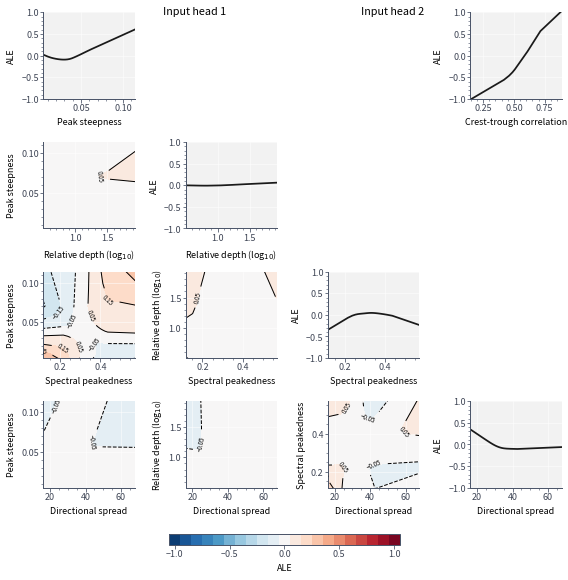

In [29]:
ale_matrix(state, x_train[df_train["sea_state_dynamic_peak_relative_depth_log10"].values > 0.5], out_prefix="generated/ale-deep")

## Evaluate all models on data subsets

In [30]:
table = {}

for subset, (sub_x, sub_y) in sub_xy_test.items():
    row = {}
    
    sdf, _ = sub_df_test[subset]

    r = sdf["sea_state_dynamic_crest_trough_correlation"].values
    bfi = sdf["sea_state_dynamic_benjamin_feir_index_peakedness"].values
    r_dir = sdf["direction_directionality_index"].values

    for cdf in [rayleigh_cdf, tayfun_cdf, janssen_cdf, hybrid_cdf]: 
        cdf_pred = logit(inflate(cdf(2.0, r, bfi, r_dir)))
        cdf_score = score(None, sub_x, sub_y, logits=cdf_pred)
        row[f"{cdf.__name__}_score"] = cdf_score

    pred_swag_orig = sample_swag(state, sub_x, *swag_out, 100)

    score_orig = score(state, sub_x, sub_y, logits=pred_swag_orig.mean(axis=1))
    row["score_orig"] = score_orig

    pred_symreg = symreg_model(sub_x)
    score_symreg = score(None, sub_x, sub_y, logits=pred_symreg)
    row["score_symreg"] = score_symreg

    table[subset] = row

meanrow = {}
for col in table["full"].keys():
    meanrow[col] = np.mean([row[col] for row in table.values()])

table["average"] = meanrow

In [31]:
table_cols = list(table["full"].keys())
fmt = " ".join(["{: >16}"] * (len(table_cols) + 1))

print(fmt.format("subset", *table_cols))
for subset, row in table.items():
    print(fmt.format(subset, *[f"{row[col]:.1e}" for col in table_cols]))

          subset rayleigh_cdf_score tayfun_cdf_score janssen_cdf_score hybrid_cdf_score       score_orig     score_symreg
southern-california         -1.5e-02          4.9e-04         -1.5e-02          5.3e-04          8.7e-04          8.0e-04
   deep-stations         -1.5e-02          4.0e-04         -1.6e-02          4.4e-04          8.9e-04          8.1e-04
shallow-stations         -1.5e-02          4.1e-04         -1.5e-02          4.2e-04          5.2e-04          5.0e-04
          summer         -1.5e-02          4.9e-04         -1.5e-02          5.1e-04          7.2e-04          6.9e-04
          winter         -1.4e-02          1.5e-04         -1.4e-02          1.9e-04          5.8e-04          5.5e-04
         Hs > 3m         -1.2e-02         -4.8e-05         -1.4e-02          1.2e-05          3.7e-04          2.9e-04
  high-frequency         -1.4e-02         -4.9e-05         -1.5e-02         -3.9e-06          1.3e-04          1.6e-04
   low-frequency         -7.1e-03         

In [32]:
from matplotlib.ticker import Locator

class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        self.linthresh = linthresh

    def __call__(self):
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))

/Users/dion/.virtualenvs/science/lib/python3.10/site-packages/matplotlib/ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/dion/.virtualenvs/science/lib/python3.10/site-packages/matplotlib/ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


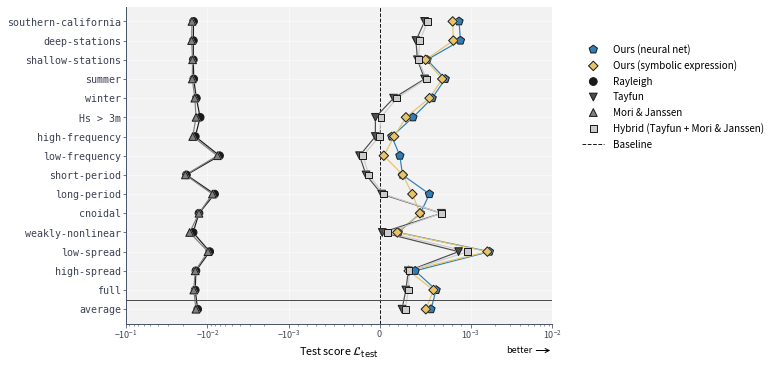

In [33]:
model_names = {
    "score_orig": "Ours (neural net)",
    "score_symreg": "Ours (symbolic expression)",
    "rayleigh_cdf_score": "Rayleigh",
    "tayfun_cdf_score": "Tayfun",
    "janssen_cdf_score": "Mori & Janssen",
    "hybrid_cdf_score": "Hybrid (Tayfun + Mori & Janssen)",
}

model_colors = {
    "score_orig": cmap(0.3),
    "score_symreg": "#e6c467",
    "rayleigh_cdf_score": "0.1",
    "tayfun_cdf_score": "0.3",
    "janssen_cdf_score": "0.5",
    "hybrid_cdf_score": "0.8",
}

model_markers = {
    "score_orig": ("p", 50),
    "score_symreg": ("D", 30),
    "rayleigh_cdf_score": ("o", 40),
    "tayfun_cdf_score": ("v", 40),
    "janssen_cdf_score": ("^", 40),
    "hybrid_cdf_score": ("s", 30),
}

model_order = [
    "score_orig",
    "score_symreg",
    "rayleigh_cdf_score",
    "tayfun_cdf_score",
    "janssen_cdf_score",
    "hybrid_cdf_score",
]

fig, ax = plt.subplots(1, 1, figsize=(8, 5.2))
from matplotlib import patheffects
path_effects = [patheffects.withStroke(linewidth=1.2, foreground="w")]

table_cols = list(table["full"].keys())
table_transposed = {col: [row[col] for row in table.values()] for col in table_cols}

for model in model_order:
    scores = table_transposed[model]
    label = model_names[model]
    marker, markersize = model_markers[model]
    color = model_colors[model]
    ax.scatter(
        scores, -np.arange(len(scores)), label=label, color=color, 
        edgecolor="0.1", marker=marker, sizes=[markersize * 1.5], 
        path_effects=path_effects, zorder=11, linewidth=1.0,
    )
    ax.plot(
        scores, -np.arange(len(scores)), color=color, linewidth=1.2, 
        linestyle="-", zorder=10, alpha=1.0
    )

ax.axhline(-len(table) + 1.5, color="0.3", linestyle="-", linewidth=1, zorder=12)
ax.axvline(0., color="0.1", linestyle="--", label="Baseline", linewidth=1.0)

ticks = list(table.keys())
ax.set_yticks(-np.arange(len(ticks)), ticks, fontfamily="monospace", fontsize=10)
ax.set_xscale("symlog", linthresh=1e-3)
ax.set_xlim(-0.1, 0.01)
ax.set_xlabel("Test score $\\mathcal{{L}}_{\\mathrm{{test}}}$", fontsize=12)
    
ax.xaxis.set_minor_locator(MinorSymLogLocator(1e-3))

fig.legend(ncol=1, frameon=False, bbox_to_anchor=(1.0, .9), loc="upper left", prop=dict(size=11), labelcolor="black")
ax.annotate("better", (1.0, -0.085), (-20, 0), fontsize=10, xycoords="axes fraction", textcoords="offset points", ha="right", va="center", arrowprops=dict(arrowstyle="->"))
fig.tight_layout()
fig.savefig("generated/scores.pdf", bbox_inches="tight")